In [13]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# reproducibility
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

# --- Base Model Definitions ---
def get_weights():
    probs = {
        "mobilized":  (0.106383 + 0.037736 + 0.147727) / 3,
        "assisted":   (0.446809 + 0.132075 + 0.272727) / 3,
        "unprepared": (0.446809 + 0.188679 + 0.204545) / 3,
    }
    # The proportion of normal
    # people should then be 1 minus each disruptor weighed proportion
    total = sum(probs.values())
    probs["normal"] = 1 - total
    return list(probs.keys()), list(probs.values())


### HELPER: Mixture Distribution Service Time (per disruptor group)

# Create a function that computes the service time for each disruptor group and
# a normal person
# It should use exponential distribution for disruptor groups with means of 7, 20, 21
# seconds for mobbilized, assisted, unprepared respectively 
# It should use uniform distribution for normal people between 1 and 2 seconds
def compute_service_time(group):
    if group == "mobilized":
        return np.random.exponential(7)
    elif group == "assisted":
        return np.random.exponential(20)
    elif group == "unprepared":
        return np.random.exponential(21)
    elif group == "normal":
        return np.random.uniform(1, 2)
    else:
        raise ValueError("Invalid group")


# Compute lambda 

def shift_data(shift_time):
    # Compute lambda for the shift
    if shift_time == "8am":
        lamda = compute_lambda(249)
    elif shift_time == "12pm":
        lamda = compute_lambda(322)
    elif shift_time == "4pm":
        lamda = compute_lambda(446)
    else:
        raise ValueError("Invalid shift time")

    # Save wrong exitors for each shift, it is 4 for 8am and 12 for
    # for the other shifts
    if shift_time == "8am":
        wrong_exitors = 4
    elif shift_time == "12pm":
        wrong_exitors = 12
    elif shift_time == "4pm":
        wrong_exitors = 12
    else:
        raise ValueError("Invalid shift time")

    # Define lane probabilities based on the shift time
    if shift_time == "8am":
        lane_probabilities = [0.614, 0.386]
    elif shift_time == "12pm":
        lane_probabilities = [0.632, 0.368]
    elif shift_time == "4pm":
        lane_probabilities = [0.240, 0.760]
    else:
        raise ValueError("Invalid shift time")
    
    # Return a dictionary with the computed values
    return {
        "lambda": lamda,
        "lane_probabilities": lane_probabilities,
        "wrong_exitors": wrong_exitors
    }

# Compute the lambda value for the queuing system based on the total number of customers
# for each shift which is 249, 322, 446 for 8am, 12pm, and 4pm respectively
# It should be computed as (total number of people) / (shift duration in seconds)*(2 lanes)
def compute_lambda(total_customers):
    shift_duration_seconds = 30 * 60  # Shift duration in seconds (30 minutes)
    lanes = 2  # Number of lanes
    lamda = total_customers / (shift_duration_seconds * lanes)
    return lamda

# Print each lambda value for each shift to 4 decimal places
def print_lambda(total_customers):
    lamda = compute_lambda(total_customers)
    print(f"Lambda: {lamda:.4f}")

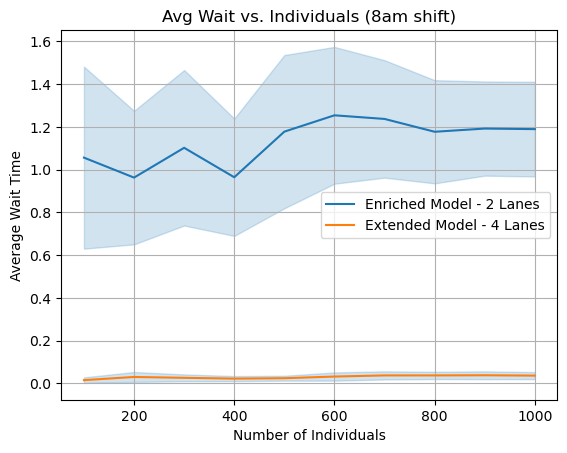

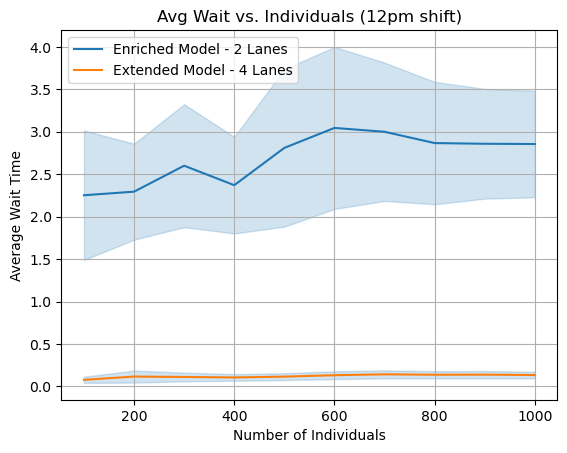

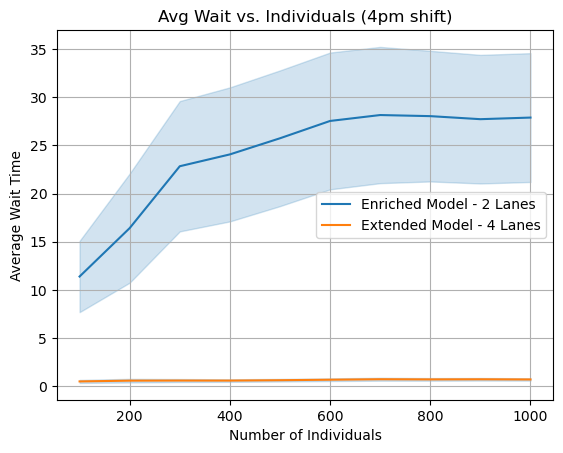

In [14]:
def final_queue_simulation_model(shift, num_customers=500, shift_duration=1800):
    # Compares the original enriched model with the extended model
    lam, lane_probs, num_wrong = shift_data(shift).values()
    types, probs = get_weights()
    wrong_exitors = np.linspace(0, shift_duration, num_wrong, endpoint=False)
    scanners = {"lane_1": [0]*3, "lane_2": [0]*3}
    now = 0.0
    wrong_idx = 0
    wait_times = []
    for _ in range(num_customers):
        now += np.random.exponential(1 / (2 * lam))
        lane = random.choices(["lane_1", "lane_2"], weights=lane_probs)[0]
        ctype = random.choices(types, weights=probs)[0]
        if ctype == "normal":
            svc = np.random.uniform(1, 2)
        else:
            svc = max(np.random.exponential(compute_service_time(ctype)), 1)
        times = scanners[lane]
        available = [i for i, t in enumerate(times) if t <= now]
        if available:
            idx, start, w = available[0], now, 0.0
        else:
            idx = int(np.argmin(times))
            start = times[idx]
            w = start - now
        # account for wrong exitors
        while wrong_idx < len(wrong_exitors) and wrong_exitors[wrong_idx] <= start:
            if lane == "lane_2":
                for i in range(3):
                    if scanners[lane][i] > wrong_exitors[wrong_idx]:
                        scanners[lane][i] += 3
            wrong_idx += 1
        scanners[lane][idx] = start + svc
        wait_times.append(w)
    return pd.DataFrame({"wait_time": wait_times})

# Extended Model #
##### This is different than the enriched model version because it is our new model
##### based on 4 lanes instead of 2

np.random.seed(42)
random.seed(42)

def extended_dynamic_model(shift_time, num_customers=500):
    lam = shift_data(shift_time)["lambda"]
    groups, weights = get_weights()

    # Define global scanner pool: lane 1 (1 scanner), lane 2 (2), lane 3 (2), lane 4 (1)
    scanner_config = {
        1: [0],       
        2: [0, 0],    
        3: [0, 0],    
        4: [0]        
    }

    arrivals = np.zeros(num_customers)
    service_times = np.zeros(num_customers)
    wait_times = np.zeros(num_customers)
    lanes = np.zeros(num_customers, dtype=int)
    groups_array = np.zeros(num_customers, dtype=object)

    now = 0.0

    for i in range(num_customers):
        # Arrival
        interarrival_time = np.random.exponential(1 / (lam * 2))  
        now += interarrival_time

        group = np.random.choice(groups, p=weights)
        service_time = compute_service_time(group)

        # Find earliest available scanner across all lanes
        next_lane, next_scanner, free_time = min(
            ((lane, idx, t)
             for lane, scanners in scanner_config.items()
             for idx, t in enumerate(scanners)),
            key=lambda x: x[2]
        )

        # Assign wait and start
        if free_time <= now:
            wait_time = 0.0
            start = now
        else:
            wait_time = free_time - now
            start = free_time

        # Update that scanner's availability
        scanner_config[next_lane][next_scanner] = start + service_time

        # Log data
        arrivals[i] = now
        service_times[i] = service_time
        wait_times[i] = wait_time
        lanes[i] = next_lane
        groups_array[i] = group

    return pd.DataFrame({"wait": wait_times})

# Avg wait shortcuts 
def get_avg_wait_enriched(shift, n_customers):
    return final_queue_simulation_model(shift, n_customers)["wait_time"].mean()

def get_avg_wait_extended(shift, n_customers):
    return extended_dynamic_model(shift, n_customers)["wait"].mean()

# 95% CI helper for Enriched model
def ci_avg_wait_enriched(shift, num_customers, reps=30, alpha=0.05):
    """
    Returns (mean, lower_CI, upper_CI) for the base-model avg wait
    using `reps` independent replications.
    """
    samples = []
    for i in range(reps):
        # reseed per replication for independence
        np.random.seed(GLOBAL_SEED + i)
        random.seed(GLOBAL_SEED + i)
        samples.append(get_avg_wait_enriched(shift, num_customers))
    samples = np.array(samples)
    mean = samples.mean()
    sem  = stats.sem(samples)
    t    = stats.t.ppf(1 - alpha/2, df=reps-1)
    margin = t * sem
    return mean, mean - margin, mean + margin
#95 % CI Helper for Extended Model
from scipy import stats

def ci_avg_wait_extended(shift, num_customers, reps=30, alpha=0.05):
    # Returns the confidence interval 
    samples = []
    for i in range(reps):
        # Independent samples
        np.random.seed(GLOBAL_SEED + 1000 + i)
        random.seed(GLOBAL_SEED + 1000 + i)
        samples.append(get_avg_wait_extended(shift, num_customers))
    samples = np.array(samples)
    mean = samples.mean()
    sem  = stats.sem(samples)
    t    = stats.t.ppf(1 - alpha/2, df=reps-1)
    margin = t * sem
    return mean, mean - margin, mean + margin

# Charts on the Confidence Interval
shifts = ["8am", "12pm", "4pm"]
customer_counts = list(range(100, 1100, 100))

for shift in shifts:
    enriched_stats = [ci_avg_wait_enriched(shift, n, reps=50) for n in customer_counts] # 100 replications, bootstrapping
    extended_states  = [ci_avg_wait_extended(shift, n, reps = 50) for n in customer_counts]

    # for the 
    enriched_means = [m for m, lo, hi in enriched_stats]
    enriched_lows  = [lo for m, lo, hi in enriched_stats]
    enriched_highs = [hi for m, lo, hi in enriched_stats]

    #unpack for optimal
    extended_means = [m for m, lo, hi in extended_states]
    extended_lows  = [lo for m, lo, hi in extended_states]
    extended_highs = [hi for m, lo, hi in extended_states]


    plt.figure()
    # plot base mean + 95% CI band
    plt.plot(customer_counts, enriched_means, label="Enriched Model - 2 Lanes")
    plt.fill_between(customer_counts, enriched_lows, enriched_highs,
                     color="C0", alpha=0.2)
    # plot optimized model mean
    plt.plot(customer_counts, extended_means, label="Extended Model - 4 Lanes")
    plt.fill_between(customer_counts, extended_lows, extended_highs,
                     color="C0", alpha=0.2)
    plt.xlabel("Number of Individuals")
    plt.ylabel("Average Wait Time")
    plt.title(f"Avg Wait vs. Individuals ({shift} shift)")
    plt.legend()
    plt.grid(True)
    plt.show()